# Assignment 7 :Multi-class Classification on Stack Overflow Questions

# Text classification

A Multiclass classifier to perform analysis on an Stack Overflow dataset.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import tarfile
import urllib
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.13.0


## Analysis

This notebook trains a analysis model to classify labels of questions. 


### Download and explore the Stack Overflow dataset

Let's download and extract the dataset, then explore the directory structure.

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

# Download the dataset
dataset_tar_path = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                           cache_dir='.',
                                           cache_subdir='')

# Create a destination directory for extraction
extracted_dir = os.path.join(os.path.dirname(dataset_tar_path), 'stack_overflow_16k')

# Extract the dataset
with tarfile.open(dataset_tar_path, "r:gz") as tar:
    tar.extractall(extracted_dir)

# List the files in the dataset directory
print(os.listdir(extracted_dir))


['README.md', 'test', 'train']


In [4]:
train_dir = os.path.join(extracted_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The Stack Overflow dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [5]:
batch_size = 32
seed = 42

#train dataset
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As you can see above, there are 8000 examples in the training folder, of which you will use 80% (or 6400) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Question", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [7]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Next, you will create a validation and test dataset.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [8]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
   'stack_overflow_16k/train', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Prepare the dataset for training

Next, standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [11]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, we will create a `TextVectorization` layer. We will use this layer to standardize, tokenize, and vectorize our data. YWe set the `output_mode` to `int` to create unique integer indices for each token.

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [14]:
# function to see the result of using this layer to preprocess some data.

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 questions and labels) from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized question", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of ex

As, we can see above, each token has been replaced by an integer. We can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [16]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


we are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [17]:
# applying the TextVectorization layer on the train, validation, and test dataset.

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. 
`.prefetch()` overlaps data preprocessing and model execution while training. 

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a four output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training.

Now, configure the model to use an optimizer and a loss function:

In [21]:
#configure the model to use an optimizer and a loss function

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

We will train the model by passing the `dataset` object to the fit method.

In [22]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 5s 20ms/step - loss: 1.3785 - accuracy: 0.3331 - val_loss: 1.3673 - val_accuracy: 0.4650
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3518 - accuracy: 0.4464 - val_loss: 1.3322 - val_accuracy: 0.5131
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3052 - accuracy: 0.5209 - val_loss: 1.2767 - val_accuracy: 0.5756
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2396 - accuracy: 0.5841 - val_loss: 1.2057 - val_accuracy: 0.6425
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1631 - accuracy: 0.6369 - val_loss: 1.1280 - val_accuracy: 0.6750
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0839 - accuracy: 0.6772 - val_loss: 1.0536 - val_accuracy: 0.7013
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0097 - accuracy: 0.7119 - val_loss: 0.9865 - val_accuracy: 0.7188
Epoch

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [23]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.8012 - accuracy: 0.7822
Loss:  0.8012401461601257
Accuracy:  0.7822499871253967


### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

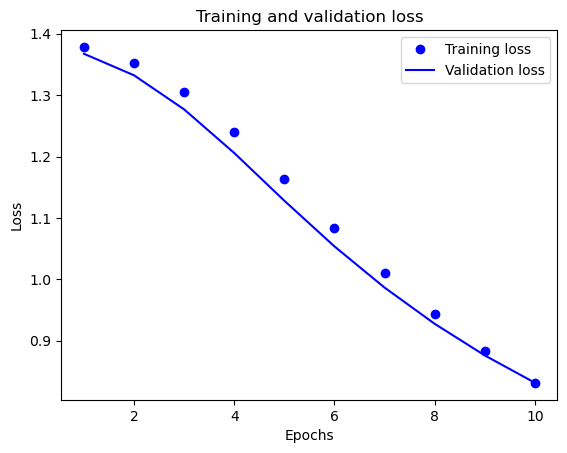

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

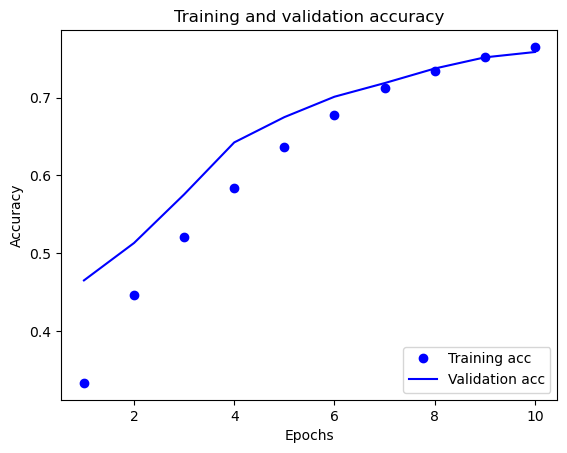

In [26]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In the code above, we applied the `TextVectorization` layer to the dataset before feeding text to the model. 

In [27]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

C:\Users\patel\anaconda3\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 2s 7ms/step - loss: 0.8012 - accuracy: 0.7822
0.7822499871253967


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [28]:
examples = [
  "How do you reverse a string in csharp?",
  "can I sort a dictionary by value in javascript?"
]

probabilities = export_model.predict(examples)

1/1 [==============================] - 0s 134ms/step


In [29]:
# Get the predicted labels for each question
predicted_labels = [raw_train_ds.class_names[np.argmax(prob)] for prob in probabilities]

print(predicted_labels)

['csharp', 'javascript']
